In [1]:
import numpy as np
import math
from numba import jit, vectorize, njit, float32, cuda

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def log_v(x):
    return np.log(x)

@vectorize([float32(float32)], target='parallel', fastmath=True)
def e_v(x):
    return np.exp(x)

A = np.array([2,5,10,3,8],dtype=np.float32)

print(log_v(A))
print(e_v(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exercise 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [3]:
def gauss(x, mean, sigma):
    return np.exp( ((x-mean)**2)/(2*sigma**2) )/np.sqrt(2*np.pi*sigma**2)

@jit(nopython=True, fastmath=True, cache=True)
def gauss_jit(x, mean, sigma):
    return np.exp( ((x-mean)**2)/(2*sigma**2) )/np.sqrt(2*np.pi*sigma**2)

x = np.linspace(-3,3,100000, dtype=np.float32)

%timeit gauss(x,1,1)
%timeit gauss_jit(x,1,1)

335 µs ± 927 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
123 µs ± 748 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

181 µs ± 140 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
53.6 µs ± 127 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


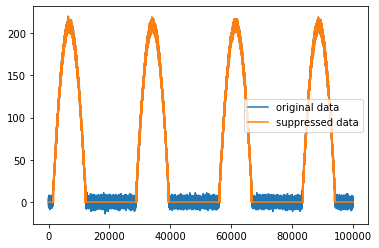

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt


def zero_suppression(signal,threshold):
    signal_supp = signal.copy()
    signal_supp[np.abs(signal_supp)<threshold] = 0
    return signal_supp

@jit(nopython=True)
def zero_suppression_jit(signal,threshold):
    signal_supp = signal.copy()
    signal_supp[np.abs(signal_supp)<threshold] = 0
    return signal_supp

n = 100000
threshold = 15
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

%timeit zero_suppression(data,threshold)
%timeit zero_suppression_jit(data,threshold)

fig, ax = plt.subplots()
ax.plot(data, label="original data")
ax.plot(zero_suppression_jit(data, threshold), label="suppressed data")
ax.legend();

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

def sig_kernel(alpha,c,x,y):
    return np.tanh(alpha*np.dot(x.T,y)+c)

@jit(nopython=True)
def sig_kernel_jit(alpha,c,x,y):
    return np.tanh(alpha*np.dot(x.T,y)+c)

@cuda.jit
def sig_kernel_cuda(alpha,c,x,y,res):
    row, col = cuda.grid(2)
    if row < res.shape[0] and col < res.shape[1]:
        tmp = 0.
        for i in range(x.shape[1]):
            tmp += x[i, row] * y[i, col]
        res[row, col] = math.tanh(alpha*tmp+c)


res = np.zeros(9).reshape(3,3) 
    
threadsperblock = (3,3)
blockspergrid_x = int(math.ceil(X.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(Y.shape[0] / threadsperblock[0]))
blockspergrid = (blockspergrid_x, blockspergrid_y)
        
%timeit sig_kernel(1,1,X,Y)
%timeit sig_kernel_jit(1,1,X,Y)
%timeit sig_kernel_cuda[threadsperblock, blockspergrid](1,1,X,Y, res)

print(sig_kernel(1,1,X,Y))
print(sig_kernel_jit(1,1,X,Y))
print(res) # not worth for such small matrixes 


4.36 µs ± 17.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.26 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
990 µs ± 33 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
[[0.88263841 0.89061339 0.8808284 ]
 [0.94530409 0.96941316 0.97758302]
 [0.87603407 0.90711827 0.92442373]]
[[0.88263841 0.89061339 0.8808284 ]
 [0.94530409 0.96941316 0.97758302]
 [0.87603407 0.90711827 0.92442373]]
[[0.88263841 0.89061339 0.8808284 ]
 [0.94530409 0.96941316 0.97758302]
 [0.87603407 0.90711827 0.92442373]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [6]:
@cuda.jit
def cos_kernel_3D(data):
    row, col, depth = cuda.grid(3)
    if row < data.shape[0] and col < data.shape[1] and depth < data.shape[2]:
        data[row][col][depth] =  math.cos(data[row][col][depth]) 
        
data = np.random.rand(256,256,256)

threadsperblock = (8,8,8) #ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

print(data)

%timeit np.cos(data)
%timeit cos_kernel_3D[blockspergrid, threadsperblock](data)
# in this case the penalty for the memory access is mitigated by the gpu being faster computing the matrix multiplication for such large matrixes


[[[0.34643229 0.25160663 0.13697369 ... 0.93264222 0.93936604 0.43880873]
  [0.90568287 0.94644285 0.48878601 ... 0.58436697 0.70212728 0.10904565]
  [0.30393425 0.54329708 0.14007013 ... 0.51362881 0.60349414 0.33258909]
  ...
  [0.86929155 0.96106521 0.35306032 ... 0.25071459 0.62484536 0.11356238]
  [0.18043099 0.89766672 0.75022133 ... 0.24568426 0.86681639 0.68153415]
  [0.91962321 0.79437463 0.7802976  ... 0.08000783 0.81790699 0.10173693]]

 [[0.75553909 0.2408156  0.09801151 ... 0.0591024  0.85361049 0.48487922]
  [0.66124365 0.5205153  0.75259958 ... 0.52034362 0.21041081 0.85403593]
  [0.19377186 0.4680537  0.37564866 ... 0.03390408 0.6967559  0.50098187]
  ...
  [0.08149714 0.11895491 0.67561993 ... 0.04854371 0.64352552 0.6373565 ]
  [0.76588269 0.51320995 0.4179958  ... 0.254774   0.82068282 0.65524454]
  [0.84685902 0.46955186 0.29649038 ... 0.78401581 0.46238807 0.29903636]]

 [[0.99646244 0.58151011 0.01142159 ... 0.7669288  0.64403678 0.73912973]
  [0.52897911 0.721827

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [7]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(low=1,high=100,size=(24,12))
B = np.random.randint(low=1,high=100,size=(12,22))
C = np.zeros((24,22))

# Configure the blocks
threadsperblock = (12,11)
blockspergrid_x =  int(math.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y =  int(math.ceil(C.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

%timeit np.dot(A,B)
%timeit matmul[blockspergrid,threadsperblock](A,B,C) #not worth for memory reasons, better implementation from numba doc for quare mat
np.allclose(C,np.dot(A,B))



5.43 µs ± 7.61 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
970 µs ± 2.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


True